<a href="https://colab.research.google.com/github/jmestanza/PASA_TP1_Echo_cancellation/blob/master/FastBlockNLMS_and_NMLS_mejora_conv.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

## Simulación de la respuesta al impulso de la habitación

In [1]:
#!/usr/bin/env python3
# -*- coding: utf-8 -*-
""" Example for computing the RIR between several sources and receivers in GPU.
"""
!pip install https://github.com/DavidDiazGuerra/gpuRIR/zipball/master
import numpy as np
import numpy.matlib
import matplotlib.pyplot as plt
from math import ceil

import gpuRIR

     - 706kB 2.8MB/s
  Created wheel for gpuRIR: filename=gpuRIR-1.2.0-cp36-cp36m-linux_x86_64.whl size=907218 sha256=f71c90c6ff74b72240dafd1048d87a0102ca7436506ce1f8b08fff458aa615e8
  Stored in directory: /tmp/pip-ephem-wheel-cache-r76_aurn/wheels/d6/80/3f/6af7d0e500b38d174f793d6b8ff6a0984b1eab8b2c8f6665ae
Successfully built gpuRIR


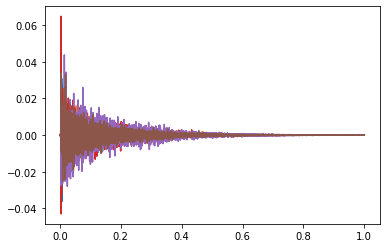

In [20]:

gpuRIR.activateMixedPrecision(False)

room_sz = [3,3,2.5]  # Size of the room [m]
nb_src = 2  # Number of sources
pos_src = np.array([[1,2.9,0.5],[1,2,0.5]]) # Positions of the sources ([m]
nb_rcv = 3 # Number of receivers
pos_rcv = np.array([[0.5,1,0.5],[1,1,0.5],[1.5,1,0.5]])	 # Position of the receivers [m]
orV_rcv = np.matlib.repmat(np.array([0,1,0]), nb_rcv, 1) # Vectors pointing in the same direction than the receivers
mic_pattern = "card" # Receiver polar pattern
abs_weights = [0.9]*5+[0.5] # Absortion coefficient ratios of the walls
T60 = 1.0	 # Time for the RIR to reach 60dB of attenuation [s]
att_diff = 15.0	# Attenuation when start using the diffuse reverberation model [dB]
att_max = 60.0 # Attenuation at the end of the simulation [dB]
fs=16000.0 # Sampling frequency [Hz]

beta = gpuRIR.beta_SabineEstimation(room_sz, T60, abs_weights=abs_weights) # Reflection coefficients
Tdiff= gpuRIR.att2t_SabineEstimator(att_diff, T60) # Time to start the diffuse reverberation model [s]
Tmax = gpuRIR.att2t_SabineEstimator(att_max, T60)	 # Time to stop the simulation [s]
nb_img = gpuRIR.t2n( Tdiff, room_sz )	# Number of image sources in each dimension
RIRs = gpuRIR.simulateRIR(room_sz, beta, pos_src, pos_rcv, nb_img, Tmax, fs, Tdiff=Tdiff, orV_rcv=orV_rcv, mic_pattern=mic_pattern)

t = np.arange(int(ceil(Tmax * fs))) / fs
plt.plot(t, RIRs.reshape(nb_src*nb_rcv, -1).transpose())
plt.show()

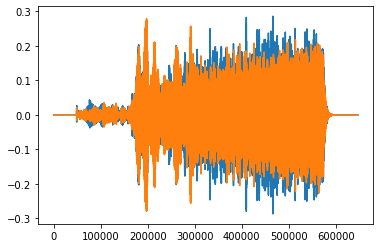

In [19]:
import numpy as np
import matplotlib.pyplot as plt
from scipy.io import wavfile
import gpuRIR
gpuRIR.activateMixedPrecision(False)

#fs, source_signal = wavfile.read('sweep_lento.wav')
fs = 44100
source_signal = uZ

room_sz = [3,4,2.5]  # Size of the room [m]
traj_pts = 64  # Number of trajectory points
pos_traj = np.tile(np.array([0.0,3.0,1.0]), (traj_pts,1))
pos_traj[:,0] = np.linspace(0.1, 2.9, traj_pts) # Positions of the trajectory points [m]
nb_rcv = 2 # Number of receivers
pos_rcv = np.array([[1.4,1,1.5],[1.6,1,1.5]])	 # Position of the receivers [m]
orV_rcv = np.array([[-1,0,0],[1,0,0]])
mic_pattern = "card" # Receiver polar pattern
T60 = 0.6 # Time for the RIR to reach 60dB of attenuation [s]
att_diff = 15.0	# Attenuation when start using the diffuse reverberation model [dB]
att_max = 60.0 # Attenuation at the end of the simulation [dB]

beta = gpuRIR.beta_SabineEstimation(room_sz, T60) # Reflection coefficients
Tdiff= gpuRIR.att2t_SabineEstimator(att_diff, T60) # Time to start the diffuse reverberation model [s]
Tmax = gpuRIR.att2t_SabineEstimator(att_max, T60)	 # Time to stop the simulation [s]
nb_img = gpuRIR.t2n( Tdiff, room_sz )	# Number of image sources in each dimension
RIRs = gpuRIR.simulateRIR(room_sz, beta, pos_traj, pos_rcv, nb_img, Tmax, fs, Tdiff=Tdiff, orV_rcv=orV_rcv, mic_pattern=mic_pattern)

filtered_signal = gpuRIR.simulateTrajectory(source_signal, RIRs)
wavfile.write('filtered_signal.wav', fs, filtered_signal)
plt.plot(filtered_signal)
plt.show()

##Obtención de datos de prueba para los algoritmos

In [3]:
from IPython.display import clear_output

!wget "https://raw.githubusercontent.com/jmestanza/Guia_2_PASA/master/data/grabados/grab_sweep_lento.wav"
!wget "https://raw.githubusercontent.com/jmestanza/Guia_2_PASA/master/data/originales/sweep_lento.wav"

clear_output()

import warnings
warnings.filterwarnings("ignore")
from scipy.io.wavfile import read
import numpy as np
import IPython.display as ipd
import matplotlib.pyplot as plt
import wave, struct, math, random
from IPython.display import Audio
from scipy import *

def sync_signals(u,d,init_delay,evLen,fs):
    u = u[int(0):int((evLen)*fs)]
    d = d[int((init_delay)*fs):int((init_delay+evLen)*fs)]
    return u, d

def adjustSignals(fs,u,d):
    ##Agrego ceros si alguna señal tiene diferente tamaño
    diff = len(u) - len(d)
    if(diff > 0):
        d = np.concatenate((d,[0 for _ in range(diff)]))
    elif(diff < 0):
        u = np.concatenate((u,[0 for _ in range(-diff)]))

    ##Agrego un segundo de ceros al principio y al final
    uZ = np.array([0 for i in range(0,1*fs)])
    uZ = np.concatenate((uZ,u))
    uZ = np.concatenate((uZ,[0 for i in range(0,1*fs)]))

    dZ = np.array([0 for i in range(0,1*fs)])
    dZ = np.concatenate((dZ,d))
    dZ = np.concatenate((dZ,[0 for i in range(0,1*fs)]))
    return uZ,dZ

def get_mono_array(stereo_file_name):
    file = read(stereo_file_name)
    fs = file[0]
    datos = np.array(file[1],dtype=float) 
    if len(np.shape(datos))>1: #si tiene dos canales
        ch0 = datos[:, 0]
        ch1 = datos[:, 1]
        datos = (ch0 + ch1)/2  # o lo hacemos mono
    return fs, datos


def read_wavs(audio_file,grab_file):
    file_name = grab_file
    fs, grab_audio = get_mono_array(file_name)
    grab_audio /= np.max(np.abs(grab_audio),axis=0)
    grab_audio /= np.max(np.abs(grab_audio),axis=0)
    grab_audio = grab_audio - np.mean(grab_audio)
    print("fs de la grabacion ",fs, "nombre", file_name)

    file_name = audio_file
    fs, audio = get_mono_array(file_name)

    audio /= np.max(np.abs(audio),axis=0)
    audio = audio-np.mean(audio)
    print("fs del audio ",fs, "nombre", file_name)
    return audio,grab_audio,fs

signals = {'log':['/content/sweep_lento.wav','/content/grab_sweep_lento.wav',0.648,10.936]}

sound="log"
audio,grab_audio,fs=read_wavs(signals[sound][0],signals[sound][1])

u, d= sync_signals(audio,grab_audio,signals[sound][2],signals[sound][3],fs)

uZ,dZ=adjustSignals(fs,u,d)


#r, p, sigma2d = get_estimations(uZ,dZ)
#r1,R,p1,wo,Jmin = get_filter(r,p,100,sigma2d)
#estimado = signal.filtfilt(wo,[1],u)

fs de la grabacion  48000 nombre /content/grab_sweep_lento.wav
fs del audio  48000 nombre /content/sweep_lento.wav


##Algoritmo NLMS

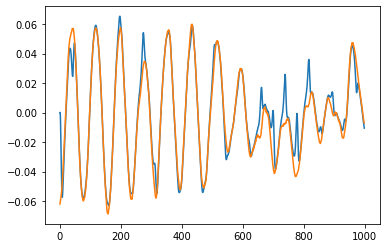

In [4]:
#NLMS Algorithm
import numpy as np
def normalize(datos):
    datos -= np.mean(datos)
    datos = np.interp(datos, (datos.min(), datos.max()), (-1, +1)) #normalizamos
    return datos

def NLMS(M, mu, delta, u, d):
    w = np.zeros((M,len(u)))
    e = np.zeros(len(u))
    u_star = np.zeros(M-1)
    uaux = np.concatenate((u_star, u), axis=None)
    y = np.zeros(len(u))
    energias_u = []
    
    for i in range(0,len(u)):
        if i == 0:
            e[0] = d[0] 
            y[0] = 0
            w[:,i]=np.zeros(M)
        else:
            y[i] = np.dot(w[:,i-1].conj().transpose(),uaux[i:i+M])
            e[i] = d[i]-y[i]
            energias_u.append(np.dot(uaux[i:i+M],uaux[i:i+M]))
            nu = mu/(np.dot(uaux[i:i+M],uaux[i:i+M]) + delta)
            w[:,i] = w[:,i-1] + nu *  uaux[i:i+M] * (e[i].conj())
    return w, np.power(e,2)/len(e), y, np.array(energias_u)

auxuz = uZ[len(uZ)//2:len(uZ)//2+1000]
auxdz = dZ[len(dZ)//2:len(dZ)//2+1000]

mu = 1
delta = 1
its = 10
M = 10

w, J, y, energias_u= NLMS(M, mu, delta, np.flip(auxuz), np.flip(auxdz))

plt.plot(y)
plt.plot(np.flip(auxdz))
plt.show()






(0.0, 100.0)

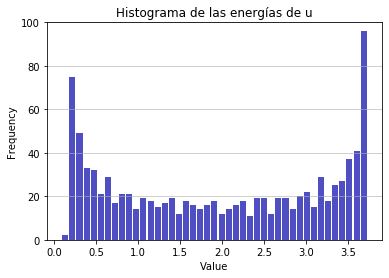

In [5]:
#ploteo de las energías de u en histograma para NLMS
n, bins, patches = plt.hist(x=energias_u, bins=43, color='#0504aa',
                            alpha=0.7, rwidth=0.85)
plt.grid(axis='y', alpha=0.75)
plt.xlabel('Value')
plt.ylabel('Frequency')
plt.title('Histograma de las energías de u')
maxfreq = n.max()
# Set a clean upper y-axis limit.
plt.ylim(ymax=np.ceil(maxfreq / 10) * 10 if maxfreq % 10 else maxfreq + 10)

##Algoritmo Fast Block LMS

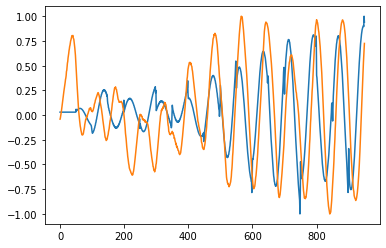

In [119]:
def normalize(datos):
    datos -= np.mean(datos)
    datos = np.interp(datos, (datos.min(), datos.max()), (-1, +1)) #normalizamos
    return datos


def getBlock(M,subArray,k):
    block = np.zeros((M,M))
    for i in range(M):
        block[:,i] = np.flip(subArray[(k*M +i): (k*M +i+M)])
    return block
def getBlocks(M,number_of_blocks,new_u,new_d):
    blocks_u = []
    blocks_d = []
    for i in range(number_of_blocks):
        blocks_u.append(getBlock(M,new_u,i)) 
        blocks_d.append(getBlock(M,new_d,i))

    blocks_u = np.array(blocks_u)
    blocks_d = np.array(blocks_d)
    return blocks_u, blocks_d

def FastBlockNLMS(M, u, d, mu, delta, gamma):
    N = 2*M
    u_list = np.zeros(0)
    d_list = np.zeros(0)
    y_list = np.zeros(0)
    W = np.zeros(N)
    W = W.astype(complex)
    original_len = len(u)
    P = np.zeros((N,N))    

    new_u = np.concatenate((np.zeros(M-1),u), axis= None)
    new_d = np.concatenate((np.zeros(M-1),d), axis= None)

    number_of_blocks = original_len//M

    blocks_u, blocks_d = getBlocks(M, number_of_blocks, new_u,new_d)

    
    # el algoritmo empieza aca
    for k in range(number_of_blocks - 1):
#    for k in range(1):
    
        u_list = np.concatenate((u_list,blocks_u[k][0,:]), axis=None)

        # concateno dos bloques
        u_concat = np.concatenate((blocks_u[k],blocks_u[k+1]),axis=1)
        u_concat = np.concatenate((u_concat,np.zeros((M,N))), axis = 0) # overlap and save
        u_concat = u_concat.astype(complex)
        for i in range(N):
            #u_concat[:,i] = np.fft.fft(u_concat[:,i]) # esto hace la fft en columnas
            u_concat[i,:] = np.fft.fft(u_concat[i,:]) # esto hace la fft en filas
            # da mejor con las filas, ademas en el resumen dice que haga fft de la cosa traspuesta 
        
        U = u_concat.diagonal() # esta U es de longitud N = 2M  

    
        for l in range(0,N):
            if l == 0:
                P[:,l] =  np.ones(N)*delta + (1-gamma) * np.power(np.abs(U),2) 
            else:
                P[:,l] = gamma*P[:,l-1] + (1-gamma) * np.power(np.abs(U),2)
        
        D = P.copy()
        D = np.power(D,-1)
        D = D.diagonal()

        y = np.fft.ifft(U*W).real
        
        y = y[len(y)-M:] 
        y_list = np.concatenate((y_list,y), axis=None)
        d = blocks_d[k][0,:]

        d_list = np.concatenate((d_list,d), axis=None)

        e = d-y
        E = np.fft.fft(np.concatenate((np.zeros(M),e),axis = None))
        #phi = np.fft.ifft((U.conj().T)*E).real[:M]
        phi = np.fft.ifft(D*(U.conj().T)*E).real[:M] 
        nu = mu/(np.dot(blocks_u[k][0,:],blocks_u[k][0,:]) + delta)
        #W += gamma*nu*np.fft.fft(np.concatenate((phi,np.zeros(M)),axis=None))
        W += gamma*np.fft.fft(np.concatenate((phi,np.zeros(M)),axis=None))
    return u_list,y_list, d_list

auxu = uZ[len(uZ)//2:len(uZ)//2+1000]
auxd = dZ[len(dZ)//2:len(dZ)//2+1000]

u_list, y_list, d_list =FastBlockNLMS(50,auxu,auxd, mu = 10, delta=1, gamma = 0.4)

plt.plot(normalize(y_list))
plt.plot(normalize(d_list))

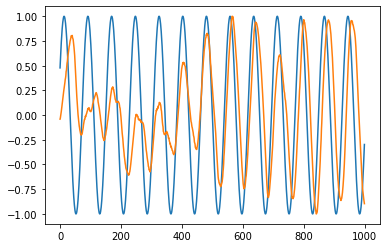

In [107]:
plt.plot(normalize(auxu))
plt.plot(normalize(auxd))

In [12]:
!pip install pandas-montecarlo
df = []

import pandas_montecarlo
mc = df['return'].montecarlo(sims=10, bust=-0.1, goal=1)

  Created wheel for pandas-montecarlo: filename=pandas_montecarlo-0.0.2-cp36-none-any.whl size=7553 sha256=cdc44895f0963ddac0ea6819e8cb470793d4df45254251ed38631fe956d6a479
  Stored in directory: /root/.cache/pip/wheels/8c/29/44/622bf8ea542ec73a0901a765b9102dd49f9e1076be3efc5411
Successfully built pandas-montecarlo


##Ejemplo adafilt

In [9]:
#remuevo adafilt si es que existe
%cd /content
!rm -rf adafilt

/content


In [0]:
# clono adafilt e instalo
%cd /content
!git clone https://github.com/fhchl/adafilt
%cd /content/adafilt 
!python setup.py install

clear_output()

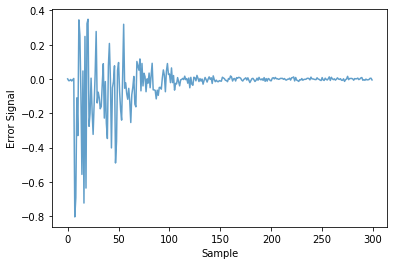

In [11]:
"""A filtered-reference Least-Mean-Square (FxLMS) filter."""

import numpy as np
import matplotlib.pyplot as plt

from adafilt import FastBlockLMSFilter, SimpleFilter
from adafilt.io import FakeInterface
from adafilt.utils import olafilt, wgn

length = 8  # number of adaptive FIR filter taps
blocklength = 2  # length of I/O buffer and blocksize of filter
n_buffers = 150  # size of simulation

# primary and secondary paths
h_pri = [0, 0, 0, 0, 0, 0, 0, 0.5]
h_sec = [0, 0, 0, 1, 0, 0, 0, 0]

# white noise signal
signal = np.random.normal(0, 1, size=n_buffers * blocklength)

# the adaptive filter
filt = FastBlockLMSFilter(length, blocklength, stepsize=0.1, leakage=0.9999)

# secondary path estimate has to account for block size
plant_model = SimpleFilter(np.concatenate((np.zeros(blocklength), h_sec)))

# simulates an audio interface with primary and secondary paths and 40 dB SNR noise
# at the error sensor
sim = FakeInterface(
    blocklength,
    signal,
    h_pri=h_pri,
    h_sec=h_sec,
    noise=wgn(olafilt(h_pri, signal), 40, "dB"),
)

elog = []
y = np.zeros(blocklength)  # control signal is zero for first block
for i in range(n_buffers):

    # record reference signal x and error signal e while playing back y
    x, e, _, _ = sim.playrec(y)

    # filter the reference signal
    fx = plant_model(x)

    # adapt filter
    filt.adapt(fx, e)

    # filter
    y = filt.filt(x)

    elog.append(e)

plt.plot(np.concatenate(elog), label="e", alpha=0.7)
plt.xlabel("Sample")
plt.ylabel("Error Signal")
plt.show()